## Features reduction

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

df = pd.read_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_train.xls")

df_full = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
df_min = df_full.min()
df_max = df_full.max()

#Drop 'protected' features
drop_cols = ['prop', 'other_prop', 'other_resp']
df = df[[col for col in df if col not in drop_cols]]

df.head()

,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
95,22000,24,50,53000,15,4.0,3.6,4.0,100
166,90000,40,60,64000,11,4.0,4.1,4.1,60
52,92000,40,45,47000,1,3.6,3.8,3.6,95
78,31000,31,40,23000,20,3.5,4.3,3.5,50
19,9000,9,10,16000,20,2.8,3.3,2.8,15


## Individual plots

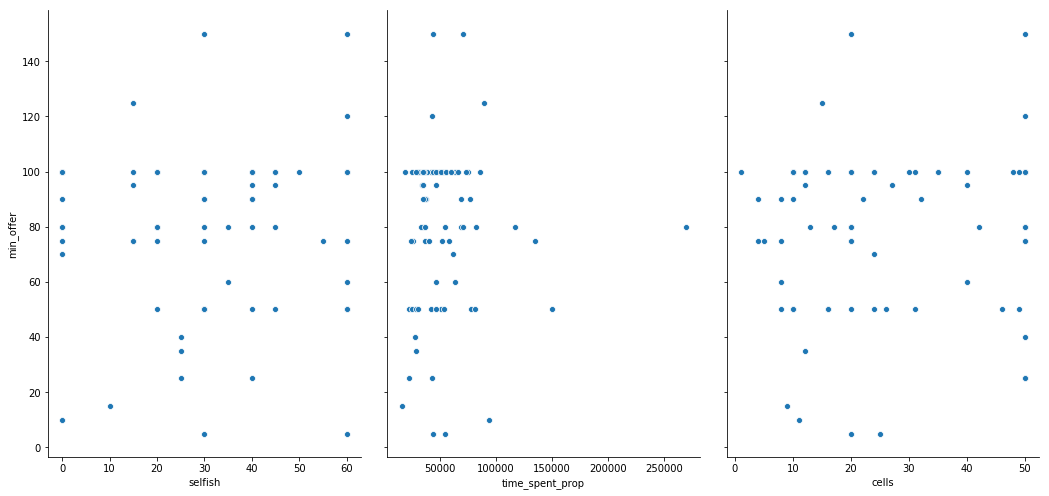

In [2]:
# sb.pairplot(df, x_vars=('prop','other_resp','other_prop'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')

sb.pairplot(df, x_vars=('selfish', 'time_spent_prop', 'cells'), y_vars='min_offer', height=7, aspect=0.7)

## Train model with top features

In [3]:
from utils.preprocessing import df_to_xy
top_columns = ['selfish', 'time_spent_prop']
#top_columns = ['cells', 'time_spent_prop']
x, y = df_to_xy(df, centered=False, select_columns=top_columns, min_target=5, max_target=190)
split = int(x.shape[0] * 0.6)
xTrain, yTrain = x[:split], y[:split]
xTest, yTest = x[split:], y[split:]
#TODO: check later

df_test = pd.read_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_test.xls")
xTest, yTest = df_to_xy(df_test, centered=False, select_columns=top_columns)

In [4]:
from sklearn.svm import SVR
from models import AcceptanceModel
model = AcceptanceModel(SVR(gamma='auto'))
model.fit(xTrain, yTrain)

Using TensorFlow backend.


In [5]:
from models.metrics import gain_mean, avg_loss_ratio, MAX_GAIN
from utils.explanation import generate_decision_area
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))
pd.DataFrame(data={"Mean gain: ": [gain_mean(yTest, yPred)], "AVG loss ratio: ": [avg_loss_ratio(yTest, yPred)]})

Mean gain:  88.8
AVG loss ratio:  0.2658386758674607


,AVG loss ratio:,Mean gain:
0,0.265839,88.8


In [6]:
print("Unique predicted values: ", np.unique(yPred))

Unique predicted values:  [ 95. 100. 105. 110. 120. 125.]


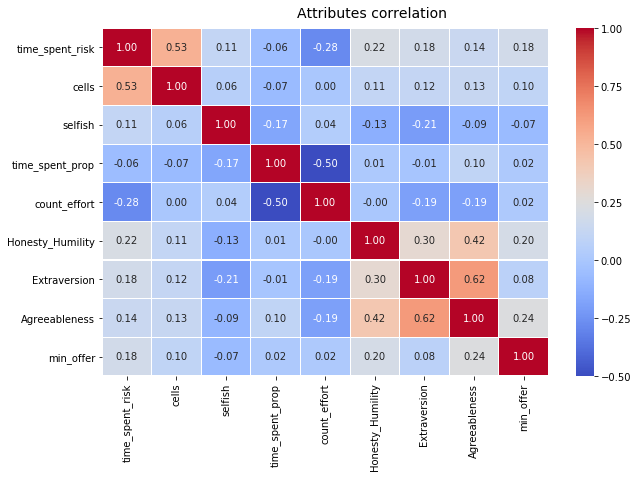

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Attributes correlation', fontsize=14)

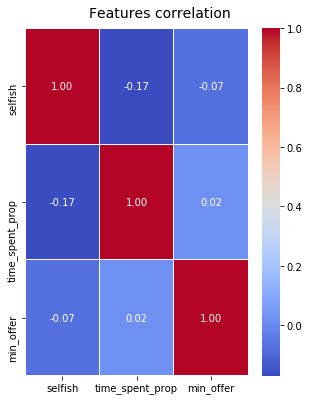

In [8]:
from utils.preprocessing import df_to_xydf
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(5, 6))
df_x, df_y = df_to_xydf(df, select_columns=top_columns, df_min=df_min, df_max=df_max)
df_corr = df_x.copy()
df_corr['min_offer'] = df_y['min_offer']
corr = df_corr.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Features correlation', fontsize=14)

**Validation DATA**

In [9]:
lbl1, lbl2 = top_columns
x1 = xTest[:, 0].ravel()
x2 = xTest[:, 1].ravel()

yPred = model.predict(xTest)

print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

Mean gain:  88.8
AVG loss ratio:  0.2658386758674607


AVG loss ratio:  0.2569123549568678


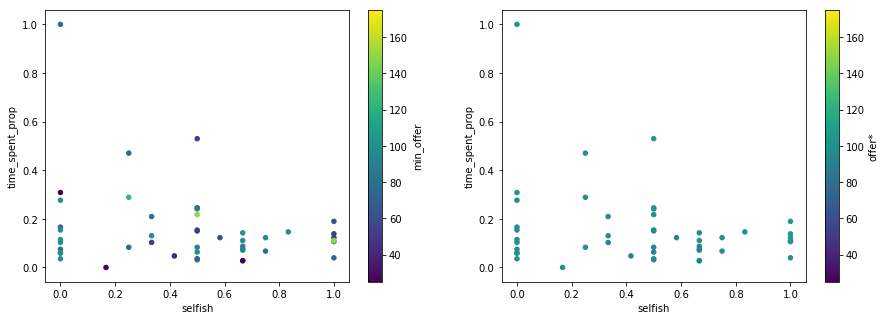

In [10]:
VMIN = 25
VMAX = 175
NB_VALUES = 64
from utils.explanation import generate_decision_area, generate_features_space_df
features_df = generate_features_space_df(nb_features=len(top_columns), nb_values=NB_VALUES, labels=top_columns)

x1 = xTrain[:, 0].ravel()
x2 = xTrain[:, 1].ravel()

yPred = model.predict(xTrain)
print("AVG loss ratio: ", avg_loss_ratio(yTrain, yPred))

fig, ax = plt.subplots(1,2,  figsize=(15, 5),)

out_df_real = pd.DataFrame({lbl1: x1, lbl2: x2, 'min_offer': yTrain.ravel()})
out_df_real.plot.scatter(x=lbl1, y=lbl2, c='min_offer', colormap='viridis', ax=ax[0], vmin=VMIN, vmax=VMAX)

#plt.subplot(1, 1, 1)
out_df_pred = pd.DataFrame({lbl1: x1, lbl2: x2, 'offer*': yPred})
out_df_pred.plot.scatter(x=lbl1, y=lbl2, c='offer*', colormap='viridis', ax=ax[1], vmin=VMIN, vmax=VMAX)

## Generate data for the survey

In [11]:
# Read and sanitize the data
df_test = pd.read_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_test.xls")

drop_cols = ['prop', 'other_prop', 'other_resp']
df_test = df_test[[col for col in df_test if col not in drop_cols]]

df_features, df_y = df_to_xydf(df_test, centered=False, select_columns=top_columns, df_min=df_min, df_max=df_max)
predictions = model.predict(df_features.values).astype(int)

df_final = df_test[top_columns].copy()
#RESCALE FEATURES
df_final['pred_min_offer'] = predictions.ravel()
df_final['min_offer'] = df_y['min_offer']
df_final.head()

,selfish,time_spent_prop,pred_min_offer,min_offer
119,0,75000,100,75
60,20,39000,100,100
158,20,41000,100,75
98,40,35000,100,60
73,0,44000,100,80


In [12]:
## df_final.to_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_test_PRED.xls", index=False)

Mean gain:  91.85
AVG loss ratio:  0.23693043292374272


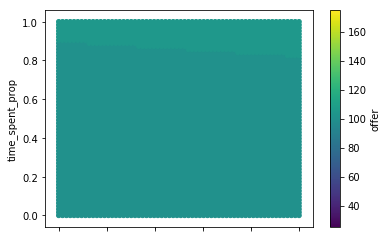

In [13]:
from models.metrics import gain_mean, avg_loss_ratio
model = AcceptanceModel()
model.fit(xTrain, yTrain)
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

# from mlxtend.plotting import plot_decision_regions
# fig = plot_decision_regions(X=xTest, y=yTest.ravel(), clf=model, legend=2)

Mean gain:  71.95
AVG loss ratio:  0.4090945801517806


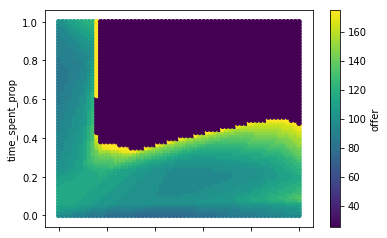

In [14]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.neural_network import MLPRegressor
model = AcceptanceModel(MLPRegressor(max_iter=1000))
model.fit(xTrain, yTrain)
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))


out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

# from mlxtend.plotting import plot_decision_regions
# fig = plot_decision_regions(X=xTest, y=yTest.ravel(), clf=model, legend=2)

Mean gain:  62.2
AVG loss ratio:  0.5168279605336739


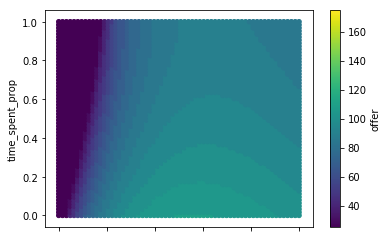

In [15]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.svm import SVR
model = AcceptanceModel(SVR(gamma='auto', kernel='sigmoid', degree=3))
model.fit(xTrain, yTrain)
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

# from mlxtend.plotting import plot_decision_regions
# fig = plot_decision_regions(X=xTest, y=yTest.ravel(), clf=model, legend=2)

Mean gain:  92.0
AVG loss ratio:  0.23566338746919724


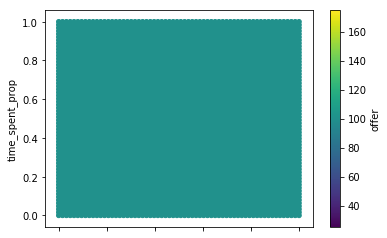

In [16]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.svm import SVC
model = SVC(gamma="auto")
model.fit(xTrain, yTrain.ravel())
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

Mean gain:  57.65
AVG loss ratio:  0.5656000888495825


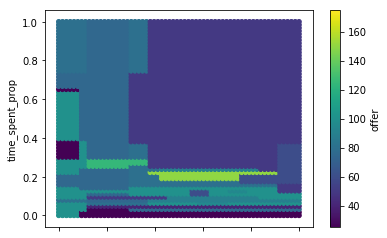

In [17]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier()
model.fit(xTrain, yTrain.ravel())
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

Mean gain:  86.5
AVG loss ratio:  0.30128775777067773


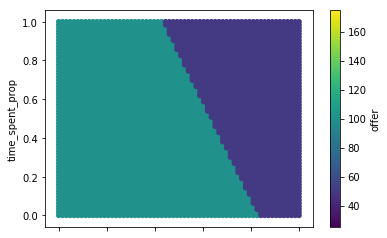

In [18]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model.fit(xTrain, yTrain.ravel())
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

/home/franck/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean gain:  59.3
AVG loss ratio:  0.5533686724890639


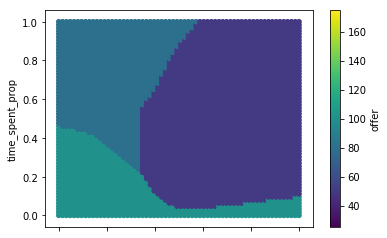

In [19]:
from models.metrics import gain_mean, avg_loss_ratio
from sklearn.neural_network import MLPClassifier
model = MLPClassifier((32, 32, 32, 32, 32))
model.fit(xTrain, yTrain.ravel())
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

Mean gain:  70.64491
AVG loss ratio:  0.4167501808819678


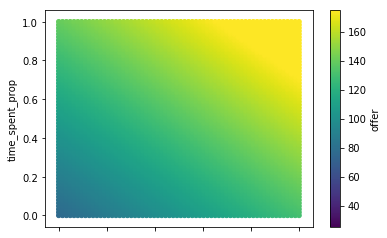

In [20]:
from models.metrics import gain_mean, avg_loss_ratio
from models import KerasModel
model = KerasModel()
model.fit(xTrain, yTrain.ravel())
yPred = model.predict(xTest)
print("Mean gain: ", gain_mean(yTest, yPred))
print("AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

out_df = generate_decision_area(model, features_df)
out_df.plot.scatter(x=lbl1, y=lbl2, c='offer', colormap='viridis', vmin=VMIN, vmax=VMAX)

In [21]:
from mlxtend.evaluate import feature_importance_permutation

coefs:  [-0.00896109 -0.06590597  2.66500529]


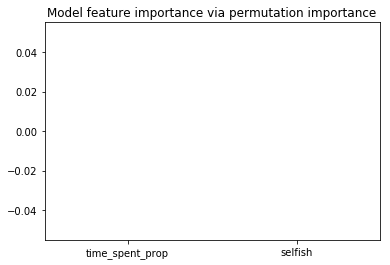

In [22]:
# from utils.benchmark import process_benchmark_cv

# process_benchmark_cv(MLPClassifier(), x, y.ravel())
model = AcceptanceModel()
model.fit(xTrain, yTrain)
print("coefs: ", model.base_model.coef_)

imp_vals, imp_all = feature_importance_permutation(
    predict_method=model.predict, 
    X=xTrain,
    y=yTrain,
    metric='accuracy',
    num_rounds=5,
    seed=5)

imp_df = pd.DataFrame({top_columns[idx]:[imp_vals[idx]] for idx in range(len(top_columns))})

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]


plt.figure()
plt.title("Model feature importance via permutation importance")
plt.bar([top_columns[idx] for idx in indices], imp_vals[indices],
        yerr=std[indices])
plt.show()

In [23]:
dx, dy = df_to_xy(df)
model = AcceptanceModel()
model.fit(dx, dy)
model.base_model.coef_

array([-0.30288435, -0.00946303,  0.07047246, -0.12319313, -0.15480853,
       -0.08870604,  0.14124961, -0.13773385,  2.67681526])

In [24]:
imp_vals, _ = feature_importance_permutation(
    predict_method=model.predict, 
    X=dx,
    y=dy,
    metric='accuracy',
    num_rounds=1,
    seed=1)

imp_vals

array([ 0.00432623, -0.00368531,  0.00929338, -0.00897292, -0.010415  ,
        0.01442077, -0.00048069, -0.00032046])

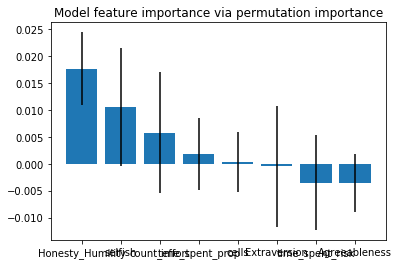

In [25]:
model = AcceptanceModel()
model.fit(dx, dy)
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model.predict, 
    X=dx,
    y=dy,
    metric='accuracy',
    num_rounds=5,
    seed=5)

#imp_df = pd.DataFrame({top_columns[idx]:[imp_vals[idx]] for idx in range(len(top_columns))})

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]


plt.figure()
plt.title("Model feature importance via permutation importance")
plt.bar([df.columns[idx] for idx in indices], imp_vals[indices],
        yerr=std[indices],)
plt.show()

In [26]:
model.fit(xTrain, yTrain)
model.base_model.predict(np.array([[0, 0, 0.99]]))

array([1.51807398])

In [27]:
pdf, bins = np.histogram(np.append(yTrain, 200), density=True, bins=np.arange(0, 201, 5))
cumpdf = np.cumsum(pdf)
cumpdf, bins

(array([0.        , 0.        , 0.00416667, 0.00833333, 0.00833333,
        0.0125    , 0.0125    , 0.0125    , 0.01666667, 0.01666667,
        0.05      , 0.05      , 0.05833333, 0.05833333, 0.05833333,
        0.07916667, 0.1       , 0.1       , 0.11666667, 0.125     ,
        0.17916667, 0.17916667, 0.17916667, 0.17916667, 0.18333333,
        0.1875    , 0.1875    , 0.1875    , 0.1875    , 0.1875    ,
        0.19583333, 0.19583333, 0.19583333, 0.19583333, 0.19583333,
        0.19583333, 0.19583333, 0.19583333, 0.19583333, 0.2       ]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
        195, 200]))

In [28]:
cumpdf/cumpdf.max()

array([0.        , 0.        , 0.02083333, 0.04166667, 0.04166667,
       0.0625    , 0.0625    , 0.0625    , 0.08333333, 0.08333333,
       0.25      , 0.25      , 0.29166667, 0.29166667, 0.29166667,
       0.39583333, 0.5       , 0.5       , 0.58333333, 0.625     ,
       0.89583333, 0.89583333, 0.89583333, 0.89583333, 0.91666667,
       0.9375    , 0.9375    , 0.9375    , 0.9375    , 0.9375    ,
       0.97916667, 0.97916667, 0.97916667, 0.97916667, 0.97916667,
       0.97916667, 0.97916667, 0.97916667, 0.97916667, 1.        ])

In [29]:
np.cumsum(cumpdf / cumpdf.sum())

array([0.00000000e+00, 0.00000000e+00, 8.88888889e-04, 2.66666667e-03,
       4.44444444e-03, 7.11111111e-03, 9.77777778e-03, 1.24444444e-02,
       1.60000000e-02, 1.95555556e-02, 3.02222222e-02, 4.08888889e-02,
       5.33333333e-02, 6.57777778e-02, 7.82222222e-02, 9.51111111e-02,
       1.16444444e-01, 1.37777778e-01, 1.62666667e-01, 1.89333333e-01,
       2.27555556e-01, 2.65777778e-01, 3.04000000e-01, 3.42222222e-01,
       3.81333333e-01, 4.21333333e-01, 4.61333333e-01, 5.01333333e-01,
       5.41333333e-01, 5.81333333e-01, 6.23111111e-01, 6.64888889e-01,
       7.06666667e-01, 7.48444444e-01, 7.90222222e-01, 8.32000000e-01,
       8.73777778e-01, 9.15555556e-01, 9.57333333e-01, 1.00000000e+00])

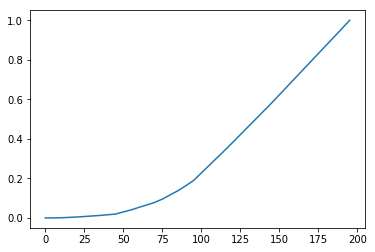

In [30]:
plt.plot(np.arange(0, 200, 5), np.cumsum(cumpdf/cumpdf.sum()))

In [31]:
v = np.arange(0, 2, 0.05)
nv = v / v.sum()

print("NV", nv)
print("NCUMPDF", cumpdf)

u = nv + cumpdf
u / u.max()

NV [0.         0.00128205 0.0025641  0.00384615 0.00512821 0.00641026
 0.00769231 0.00897436 0.01025641 0.01153846 0.01282051 0.01410256
 0.01538462 0.01666667 0.01794872 0.01923077 0.02051282 0.02179487
 0.02307692 0.02435897 0.02564103 0.02692308 0.02820513 0.02948718
 0.03076923 0.03205128 0.03333333 0.03461538 0.03589744 0.03717949
 0.03846154 0.03974359 0.04102564 0.04230769 0.04358974 0.04487179
 0.04615385 0.0474359  0.04871795 0.05      ]
NCUMPDF [0.         0.         0.00416667 0.00833333 0.00833333 0.0125
 0.0125     0.0125     0.01666667 0.01666667 0.05       0.05
 0.05833333 0.05833333 0.05833333 0.07916667 0.1        0.1
 0.11666667 0.125      0.17916667 0.17916667 0.17916667 0.17916667
 0.18333333 0.1875     0.1875     0.1875     0.1875     0.1875
 0.19583333 0.19583333 0.19583333 0.19583333 0.19583333 0.19583333
 0.19583333 0.19583333 0.19583333 0.2       ]


array([0.        , 0.00512821, 0.02692308, 0.04871795, 0.05384615,
       0.07564103, 0.08076923, 0.08589744, 0.10769231, 0.11282051,
       0.25128205, 0.25641026, 0.29487179, 0.3       , 0.30512821,
       0.39358974, 0.48205128, 0.48717949, 0.55897436, 0.5974359 ,
       0.81923077, 0.82435897, 0.82948718, 0.83461538, 0.85641026,
       0.87820513, 0.88333333, 0.88846154, 0.89358974, 0.89871795,
       0.93717949, 0.94230769, 0.9474359 , 0.9525641 , 0.95769231,
       0.96282051, 0.96794872, 0.97307692, 0.97820513, 1.        ])

In [32]:
nu = u/u.max()

In [33]:
ncumpdf[15]

NameError: name 'ncumpdf' is not defined